# Process CAS04

This notebook is shows the workflow for getting data from Earthscope for a few example stations and generating transfer functions using aurora.  The data download step is based on condensed version of a tutorial in the mth5 documentation which can be found at: https://github.com/kujaku11/mth5/tree/master/docs/examples/notebooks.  



In [1]:
#%matplotlib notebook 
%matplotlib widget


In [7]:
#Imports

import pandas as pd
import pathlib
import os
#from aurora.sandbox.mth5_channel_summary_helpers import channel_summary_to_make_mth5
from aurora.pipelines.run_summary import RunSummary
#from aurora.config import BANDS_DEFAULT_FILE
from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from aurora.transfer_function.kernel_dataset import KernelDataset
from mth5.mth5 import MTH5
from mth5.clients.make_mth5 import FDSN
from mth5.utils.helpers import initialize_mth5


In [4]:
import logging, sys
logging.disable(sys.maxsize)
import warnings
warnings.filterwarnings('ignore')

# Make MTH5 from IRIS Data Managment Center v0.2.0 

This example demonstrates how to build an MTH5 from data archived at IRIS, it could work with any MT data stored at an FDSN data center (probably).

We will use the `mth5.clients.FDSN` class to build the file.  There is also second way using the more generic `mth5.clients.MakeMTH5` class, which will be highlighted below. 

**Note:** this example assumes that data availability (Network, Station, Channel, Start, End) are all previously known.  If you do not know the data that you want to download use [IRIS tools](https://ds.iris.edu/ds/nodes/dmc/tools/##) to get data availability.   

## Initialize a MakeMTH5 object

Here, we are setting the MTH5 file version to 0.2.0 so that we can have multiple surveys in a single file.  Also, setting the client to "IRIS".  Here, we are using `obspy.clients` tools for the request.  Here are the available [FDSN clients](https://docs.obspy.org/packages/obspy.clients.fdsn.html). 

**Note:** Only the "IRIS" client has been tested.

In [8]:
fdsn_object = FDSN(mth5_version='0.2.0')
fdsn_object.client = "IRIS"

## Make the data inquiry as a DataFrame

There are a few ways to make the inquiry to request data.  

1. Make a DataFrame by hand.  Here we will make a list of entries and then create a DataFrame with the proper column names
2. You can create a CSV file with a row for each entry. There are some formatting that you need to be aware of.  That is the column names and making sure that date-times are YYYY-MM-DDThh:mm:ss


| Column Name         |   Description                                                                                                 |
| ------------------- | --------------------------------------------------------------------------------------------------------------|
| **network**         | [FDSN Network code (2 letters)](http://www.fdsn.org/networks/)                                                |
| **station**         | [FDSN Station code (usually 5 characters)](https://ds.iris.edu/ds/nodes/dmc/data/formats/seed-channel-naming/)|
| **location**        | [FDSN Location code (typically not used for MT)](http://docs.fdsn.org/projects/source-identifiers/en/v1.0/location-codes.html) |
| **channel**         | [FDSN Channel code (3 characters)](http://docs.fdsn.org/projects/source-identifiers/en/v1.0/channel-codes.html)|
| **start**           | Start time (YYYY-MM-DDThh:mm:ss) UTC |
| **end**             | End time (YYYY-MM-DDThh:mm:ss) UTC  |

In the example below, the stage is set to use two stations: CAS04 and NVR08.  Commented out is an example of how to add a third station, REV06

In [9]:
channels = ["LFE", "LFN", "LFZ", "LQE", "LQN"]
CAS04 = ["8P", "CAS04",  '2020-06-02T19:00:00', '2020-07-13T19:00:00'] 
NVR08 = ["8P", "NVR08", '2020-06-02T19:00:00', '2020-07-13T19:00:00']
# REV06 = ["8P", "REV06", '2020-06-02T19:00:00', '2020-07-13T19:00:00']

stations = [CAS04, NVR08,]
# stations.append(REV06)

request_list = []
for entry in stations:
    for channel in channels:
        request_list.append(
            [entry[0], entry[1], "", channel, entry[2], entry[3]]
        )

# Turn list into dataframe
request_df =  pd.DataFrame(request_list, columns=fdsn_object.request_columns) 
request_df

,network,station,location,channel,start,end
0,8P,CAS04,,LFE,2020-06-02T19:00:00,2020-07-13T19:00:00
1,8P,CAS04,,LFN,2020-06-02T19:00:00,2020-07-13T19:00:00
2,8P,CAS04,,LFZ,2020-06-02T19:00:00,2020-07-13T19:00:00
3,8P,CAS04,,LQE,2020-06-02T19:00:00,2020-07-13T19:00:00
4,8P,CAS04,,LQN,2020-06-02T19:00:00,2020-07-13T19:00:00
5,8P,NVR08,,LFE,2020-06-02T19:00:00,2020-07-13T19:00:00
6,8P,NVR08,,LFN,2020-06-02T19:00:00,2020-07-13T19:00:00
7,8P,NVR08,,LFZ,2020-06-02T19:00:00,2020-07-13T19:00:00
8,8P,NVR08,,LQE,2020-06-02T19:00:00,2020-07-13T19:00:00
9,8P,NVR08,,LQN,2020-06-02T19:00:00,2020-07-13T19:00:00


In [11]:
%%time

mth5_filename = fdsn_object.make_mth5_from_fdsn_client(request_df, interact=False)

print(f"Created {mth5_filename}")

2024-03-10T12:10:39.282990-0700 | WARNING | mth5.mth5 | open_mth5 | 8P_CAS04_NVR08.h5 will be overwritten in 'w' mode
2024-03-10T12:10:39.621179-0700 | INFO | mth5.mth5 | _initialize_file | Initialized MTH5 0.2.0 file /home/kkappler/software/irismt/aurora/paper/8P_CAS04_NVR08.h5 in mode w
2024-03-10T12:12:05.409106-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.
2024-03-10T12:12:05.418381-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_dipole_92.000 to a CoefficientFilter.
2024-03-10T12:12:05.468087-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosResponseStage electric_si_units to a CoefficientFilter.
2024-03-10T12:12:05.477594-0700 | INFO | mt_metadata.timeseries.filters.obspy_stages | create_filter_from_stage | Converting PoleZerosR

In [12]:
mth5_path = pathlib.Path("8P_CAS04_NVR08.h5")

In [13]:
m = initialize_mth5(mth5_path)
m.channel_summary.summarize()
df = m.channel_summary.to_dataframe()
df

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,CONUS SoCal,CAS04,a,37.633351,-121.468382,329.3875,ex,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,CONUS SoCal,CAS04,a,37.633351,-121.468382,329.3875,ey,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,CONUS SoCal,CAS04,a,37.633351,-121.468382,329.3875,hx,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,CONUS SoCal,CAS04,a,37.633351,-121.468382,329.3875,hy,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,CONUS SoCal,CAS04,a,37.633351,-121.468382,329.3875,hz,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
5,CONUS SoCal,CAS04,b,37.633351,-121.468382,329.3875,ex,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
6,CONUS SoCal,CAS04,b,37.633351,-121.468382,329.3875,ey,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
7,CONUS SoCal,CAS04,b,37.633351,-121.468382,329.3875,hx,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
8,CONUS SoCal,CAS04,b,37.633351,-121.468382,329.3875,hy,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
9,CONUS SoCal,CAS04,b,37.633351,-121.468382,329.3875,hz,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,847649,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


In [14]:
df.station.unique()

array(['CAS04', 'NVR08'], dtype=object)

In [15]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
run_summary = mth5_run_summary.clone()
run_summary.df

2024-03-10T12:20:34.769141-0700 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


,survey,station_id,run_id,start,end,sample_rate,input_channels,output_channels,channel_scale_factors,valid,mth5_path
0,CONUS SoCal,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,8P_CAS04_NVR08.h5
1,CONUS SoCal,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,8P_CAS04_NVR08.h5
2,CONUS SoCal,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,8P_CAS04_NVR08.h5
3,CONUS SoCal,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,8P_CAS04_NVR08.h5
4,CONUS SoCal,NVR08,a,2020-06-03 19:10:11+00:00,2020-06-03 19:57:51+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,8P_CAS04_NVR08.h5
5,CONUS SoCal,NVR08,b,2020-06-03 20:14:13+00:00,2020-06-14 16:56:02+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,8P_CAS04_NVR08.h5
6,CONUS SoCal,NVR08,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,8P_CAS04_NVR08.h5


In [16]:
coverage_short_list_columns = ["survey", 'station_id', 'run_id', 'start', 'end', ]
run_summary.df[coverage_short_list_columns]

,survey,station_id,run_id,start,end
0,CONUS SoCal,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00
1,CONUS SoCal,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00
2,CONUS SoCal,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00
3,CONUS SoCal,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00
4,CONUS SoCal,NVR08,a,2020-06-03 19:10:11+00:00,2020-06-03 19:57:51+00:00
5,CONUS SoCal,NVR08,b,2020-06-03 20:14:13+00:00,2020-06-14 16:56:02+00:00
6,CONUS SoCal,NVR08,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00


In [17]:
kernel_dataset = KernelDataset()
station_id = "CAS04"
remote_reference_id = "NVR08"
kernel_dataset.from_run_summary(run_summary, station_id, remote_reference_id)
kernel_dataset.mini_summary

,survey,station_id,run_id,start,end,duration
0,CONUS SoCal,CAS04,b,2020-06-03 19:10:11+00:00,2020-06-03 19:57:51+00:00,2860.0
1,CONUS SoCal,NVR08,a,2020-06-03 19:10:11+00:00,2020-06-03 19:57:51+00:00,2860.0
2,CONUS SoCal,CAS04,b,2020-06-03 20:14:13+00:00,2020-06-12 17:52:23+00:00,769090.0
3,CONUS SoCal,NVR08,b,2020-06-03 20:14:13+00:00,2020-06-12 17:52:23+00:00,769090.0
4,CONUS SoCal,CAS04,c,2020-06-12 18:32:17+00:00,2020-06-14 16:56:02+00:00,167025.0
5,CONUS SoCal,NVR08,b,2020-06-12 18:32:17+00:00,2020-06-14 16:56:02+00:00,167025.0
6,CONUS SoCal,CAS04,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00,856502.0
7,CONUS SoCal,NVR08,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00,856502.0


In [18]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, station_id, remote_reference_id)
cutoff_duration_in_seconds = 180000
kernel_dataset.drop_runs_shorter_than(cutoff_duration_in_seconds)
kernel_dataset.df[coverage_short_list_columns]

,survey,station_id,run_id,start,end
0,CONUS SoCal,CAS04,b,2020-06-03 20:14:13+00:00,2020-06-12 17:52:23+00:00
1,CONUS SoCal,NVR08,b,2020-06-03 20:14:13+00:00,2020-06-12 17:52:23+00:00
2,CONUS SoCal,CAS04,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00
3,CONUS SoCal,NVR08,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00


In [19]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset,) 
#                                       emtf_band_file=BANDS_DEFAULT_FILE,)

2024-03-10T12:20:37.101847-0700 | INFO | aurora.config.config_creator | determine_band_specification_style | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE


In [20]:
config

{
    "processing": {
        "band_setup_file": "/home/kkappler/software/irismt/aurora/aurora/config/emtf_band_setup/bs_test.cfg",
        "band_specification_style": "EMTF",
        "channel_nomenclature.ex": "ex",
        "channel_nomenclature.ey": "ey",
        "channel_nomenclature.hx": "hx",
        "channel_nomenclature.hy": "hy",
        "channel_nomenclature.hz": "hz",
        "decimations": [
            {
                "decimation_level": {
                    "anti_alias_filter": "default",
                    "bands": [
                        {
                            "band": {
                                "center_averaging_type": "geometric",
                                "closed": "left",
                                "decimation_level": 0,
                                "frequency_max": 0.23828125,
                                "frequency_min": 0.19140625,
                                "index_max": 30,
                                "index_min": 25
 

# Add Logic to save FCs

for dec_level in config.decimations:
    dec_level.window.type = "hamming"
#    dec_level.window.overlap = int(dec_level.window.num_samples/4)
    #dec_level.save_fcs = True
    #dec_level.save_fcs_type = "h5"

In [21]:
file_info = os.stat(mth5_path)
print(file_info)
print(file_info.st_size)

os.stat_result(st_mode=33204, st_ino=92440685, st_dev=66306, st_nlink=1, st_uid=1001, st_gid=1001, st_size=107293426, st_atime=1710098434, st_mtime=1710098434, st_ctime=1710098434)
107293426


In [22]:
tf_file_base = f"{station_id}_RR{remote_reference_id}"

2024-03-10T12:20:39.944467-0700 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:
2024-03-10T12:20:39.951263-0700 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | 
         survey station_id run_id  valid  remote  duration    fc dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   CONUS SoCal      CAS04      b   True   False  769090.0  None         0         1.0     1.000000            128.0                 128     769090.0            8011.0
1   CONUS SoCal      CAS04      b   True   False  769090.0  None         1         4.0     0.250000            512.0                 128     192272.0            2002.0
2   CONUS SoCal      CAS04      b   True   False  769090.0  None         2         4.0     0.062500           2048.0                 128      48068.0             500.0
3   CONUS SoCal      CAS04      b   True   False  769090.0  None         3 

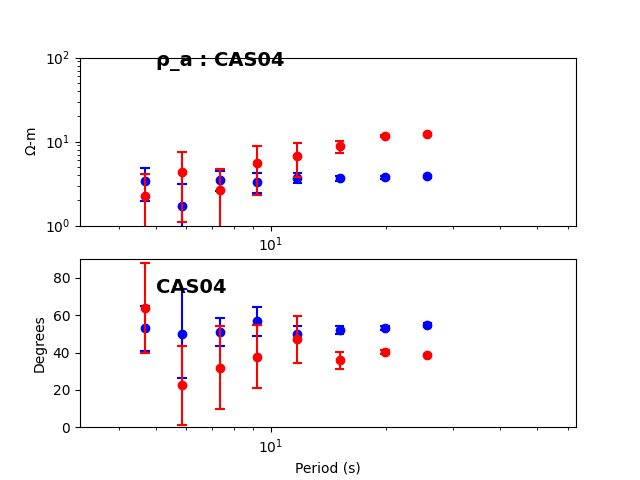

2024-03-10T12:20:51.440467-0700 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 1
2024-03-10T12:20:51.746451-0700 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 1 Successfully
2024-03-10T12:20:52.143751-0700 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-10T12:20:52.555397-0700 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-10T12:20:52.943645-0700 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-10T12:20:53.365004-0700 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-10T12:20:53.390116-0700 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_

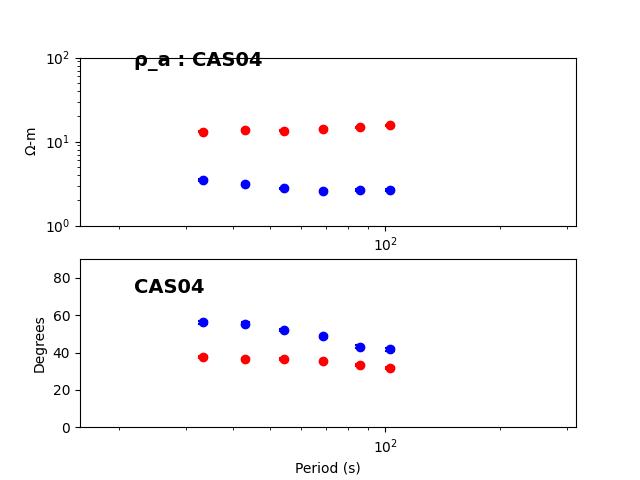

2024-03-10T12:20:54.734625-0700 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 2
2024-03-10T12:20:54.856568-0700 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 2 Successfully
2024-03-10T12:20:55.227119-0700 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-10T12:20:55.685776-0700 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-10T12:20:56.156181-0700 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-10T12:20:56.545185-0700 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-10T12:20:56.561629-0700 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_

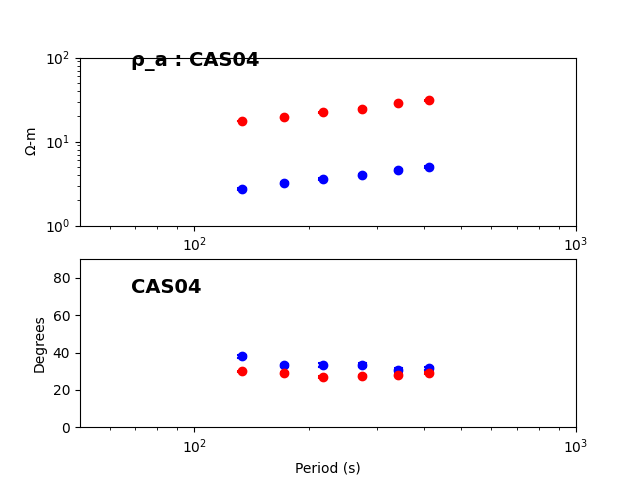

2024-03-10T12:20:57.549602-0700 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 3
2024-03-10T12:20:57.608897-0700 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 3 Successfully
2024-03-10T12:20:58.008856-0700 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-10T12:20:58.389356-0700 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-10T12:20:58.732405-0700 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-10T12:20:59.088507-0700 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-10T12:20:59.100911-0700 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_

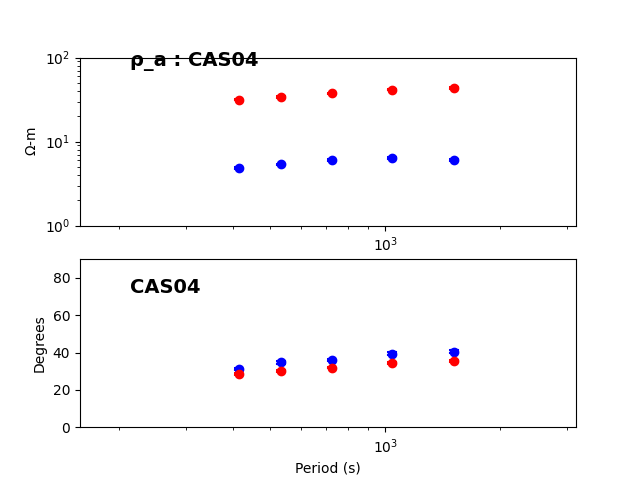

2024-03-10T12:21:00.089966-0700 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5
2024-03-10T12:21:00.171084-0700 | INFO | mth5.mth5 | close_mth5 | Flushing and closing 8P_CAS04_NVR08.h5


In [23]:
show_plot = True
z_file_path = pathlib.Path(f"{tf_file_base}.zrr")
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=z_file_path,
                )

In [17]:
tf_cls.write(fn=f"{tf_file_base}.xml", file_type="emtfxml")
tf_cls.write(fn=f"{tf_file_base}.edi", file_type="edi")
tf_cls.write(fn=f"{tf_file_base}.zrr", file_type="zrr")

MT( station='CAS04', latitude=37.63, longitude=-121.47, elevation=329.39 )

In [18]:
archived_z_file = pathlib.Path(f"CAS04bcd_REV06.zrr")

In [ ]:
from aurora.transfer_function.plot.comparison_plots import compare_two_z_files
z_file_path = "CAS04_RRNVR08.zrr"

#  To compare with the archived file, we need to set the coordinate system to geographic

The TF will be output with a header like this:

```
TRANSFER FUNCTIONS IN MEASUREMENT COORDINATES
********* WITH FULL ERROR COVARIANCE ********
Aurora Robust Remote Reference
station: CAS04
coordinate    37.633  -121.468 declination    13.17
number of channels    5  number of frequencies  25
 orientations and tilts of each channel
    1    13.20     0.00 CAS04  Hx
    2   103.20     0.00 CAS04  Hy
    3     0.00    90.00 CAS04  Hz
    4    13.20     0.00 CAS04  Ex
    5   103.20     0.00 CAS04  Ey
```

To remove the rotation, we can use a variety of tools, but another way is just to overwrite the orientations:

```
TRANSFER FUNCTIONS IN MEASUREMENT COORDINATES
********* WITH FULL ERROR COVARIANCE ********
 Aurora Robust Remote Reference
station: CAS04
coordinate    37.633  -121.468 declination    13.17
number of channels    5  number of frequencies  25
 orientations and tilts of each channel
    1     0.00     0.00 CAS04  Hx
    2    90.00     0.00 CAS04  Hy
    3     0.00    90.00 CAS04  Hz
    4     0.00     0.00 CAS04  Ex
    5    90.00     0.00 CAS04  Ey
```

This is why we set angle1=13.2 degrees in the comparison plotter.

24:03:06T18:20:42 | INFO | line:53 |aurora.transfer_function.plot.comparison_plots | compare_two_z_files | scale_factor1: 1


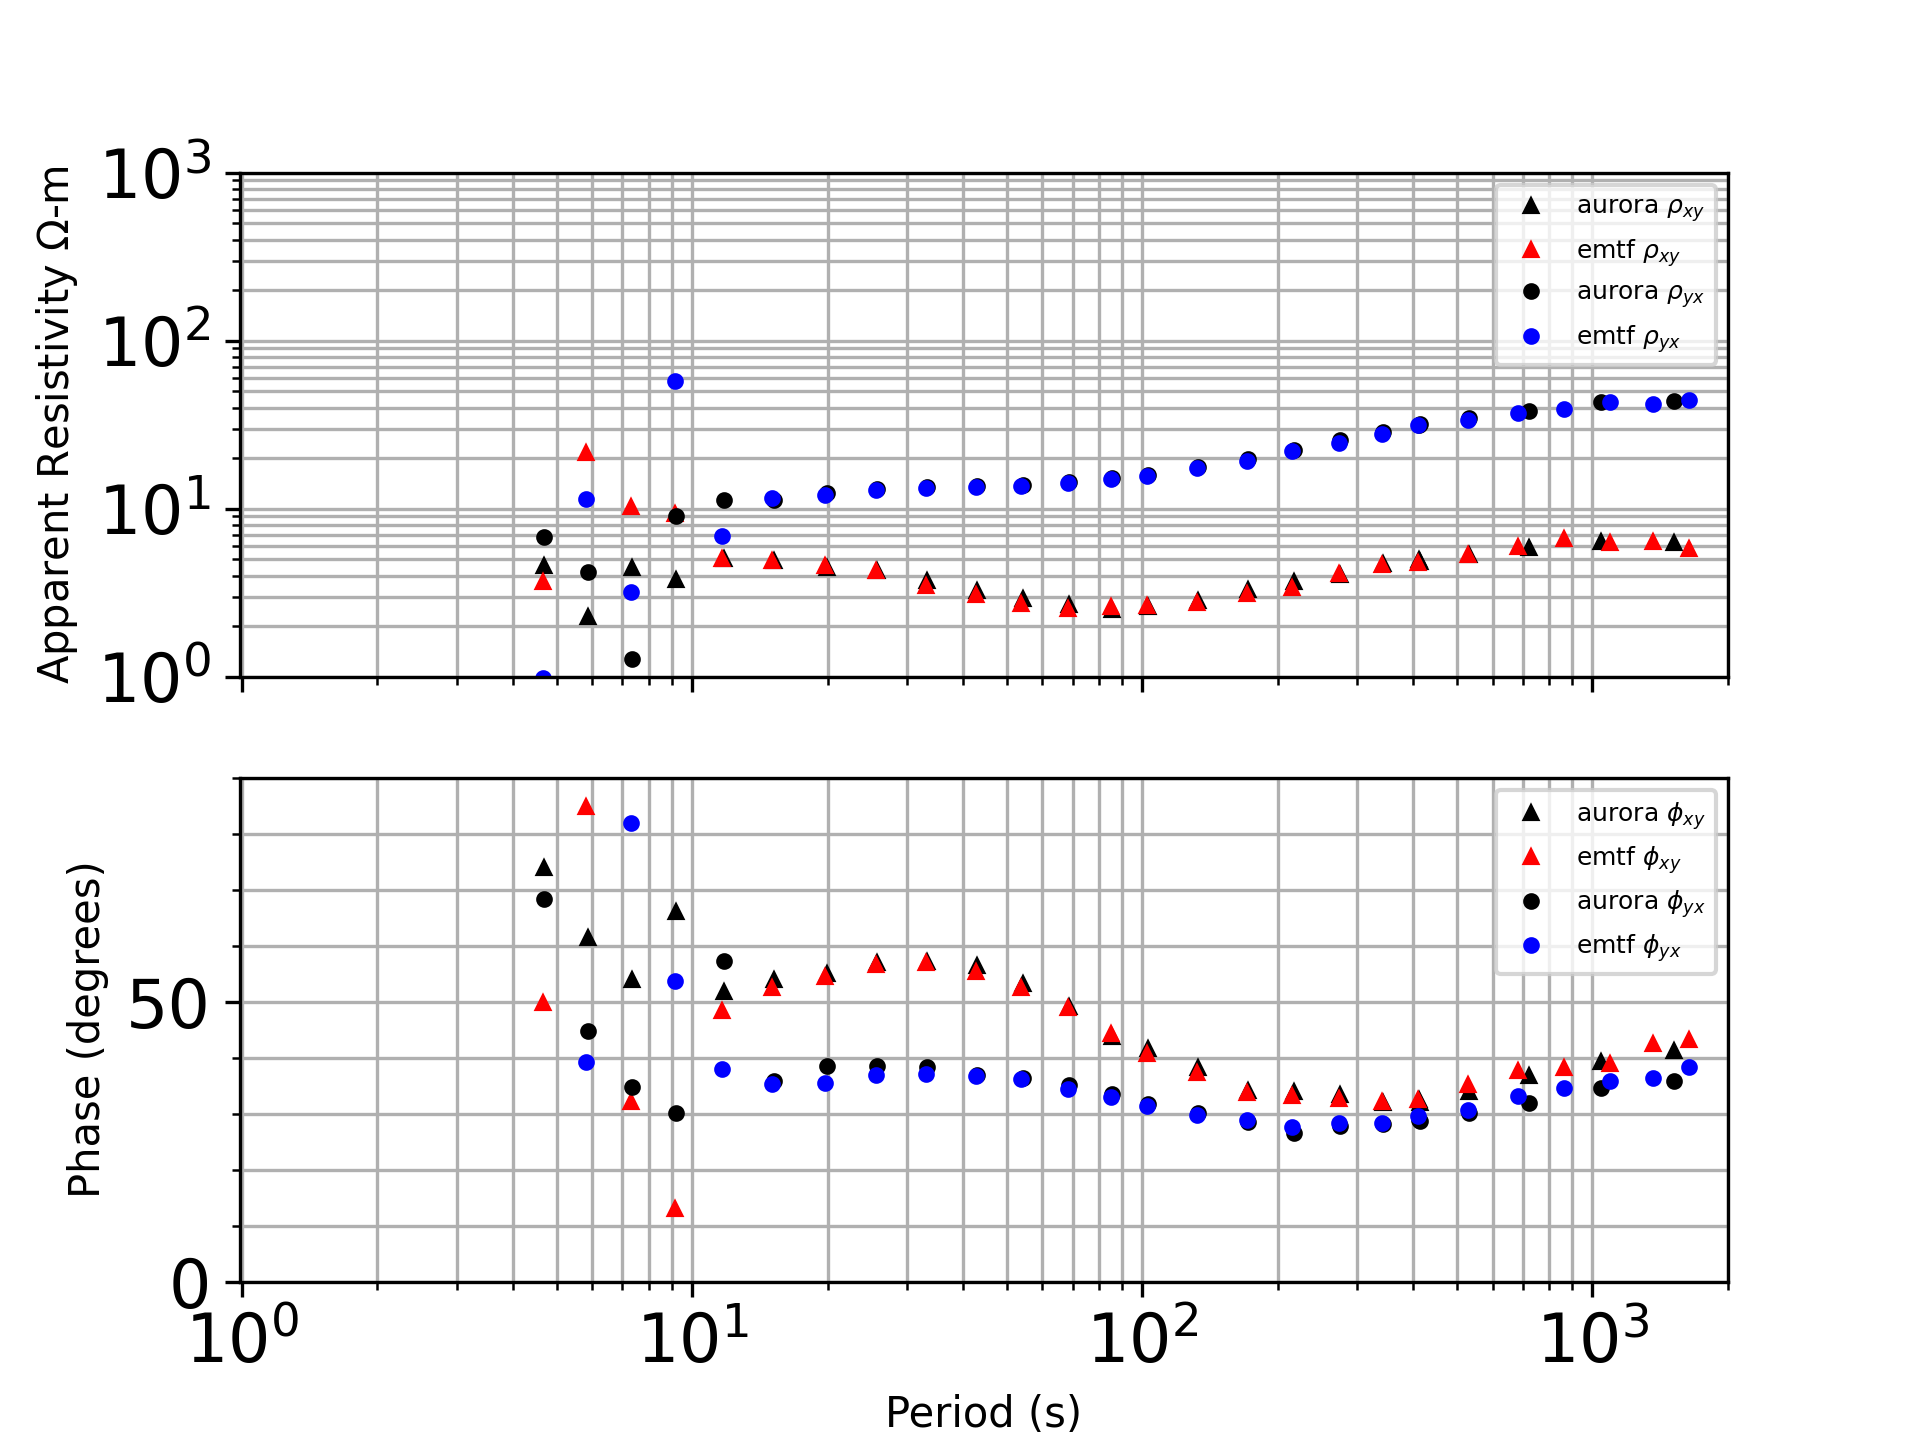

In [30]:
compare_two_z_files(
            z_file_path,
            archived_z_file,
            angle1=+13.2,
            label1="aurora",
            label2="emtf",
            scale_factor1=1,
            out_file=f"{tf_file_base}compare.png",
            markersize=3,
            rho_ylims=[1e0, 1e3],
            xlims=[0.99, 2000],
        )

# Now that the FCs are saved we can access them:|

- Access FC
- make a scatter plot
- note that these plats are slated to be put in spectrogram class

In [24]:
# Choose what specific FCs we want:
survey_id = "CONUS South"
station_id = "CAS04"
run_id = "b"
decimation_level_id = "0"

In [25]:
m = initialize_mth5(mth5_path)

In [26]:
survey_group = m.get_survey(survey_id)

24:03:06T18:17:29 | WARNING | line:1057 |mth5.mth5 | get_survey | /Experiment/Surveys/CONUS_South does not exist, check survey_list for existing names.


MTH5Error: /Experiment/Surveys/CONUS_South does not exist, check survey_list for existing names.

In [ ]:
station_obj = survey_group.stations_group.get_station(station_id)

In [ ]:
fc_group = station_obj.fourier_coefficients_group.get_fc_group(run_id)
fc_decimation_level = fc_group.get_decimation_level(decimation_level_id)
stft_obj = fc_decimation_level.to_xarray()

In [ ]:
stft_obj

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
ex = stft_obj.ex

In [ ]:
ex = ex.dropna(dim="frequency")

In [ ]:
ex

In [ ]:
ex = np.abs(ex)

In [ ]:
ex.time.data

Plotting spectrograms with dates:

The cell below was adapted from:

https://stackoverflow.com/questions/23139595/dates-in-the-xaxis-for-a-matplotlib-plot-with-imshow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.dates as mdates

import datetime as dt

x_lims = [ex.time.data[0], ex.time.data[-1]]
#list(map(dt.datetime.fromtimestamp, [982376726, 982377321]))

# You can then convert these datetime.datetime objects to the correct
# format for matplotlib to work with.
x_lims = mdates.date2num(x_lims)

# Set some generic y-limits.
y_lims = [0, 64]

fig, ax = plt.subplots()

# Using ax.imshow we set two keyword arguments. The first is extent.
# We give extent the values from x_lims and y_lims above.
# We also set the aspect to "auto" which should set the plot up nicely.
ax.imshow(np.log10(ex.T), extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]], 
          aspect='auto', origin='lower' )

# # We tell Matplotlib that the x-axis is filled with datetime data, 
# # this converts it from a float (which is the output of date2num) 
# # into a nice datetime string.
ax.xaxis_date()

# # We can use a DateFormatter to choose how this datetime string will look.
# # I have chosen HH:MM:SS though you could add DD/MM/YY if you had data
# # over different days.
date_format = mdates.DateFormatter('%Y-%m-%d')# %H:%M:%S')

ax.xaxis.set_major_formatter(date_format)

# # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time")
ax.set_title(f"log_{10} Amplitude Spectrogram for {station_id}, run {run_id}")
plt.show()

In [ ]:
#plt.clf()

In [ ]:
plt.show()

# Debug Notes
- I would expect run b (which is many days long to have much more than 29 time windows!

In [ ]:
station_obj.groups_list

In [ ]:
station_obj = survey_group.get_station("CAS04")

# Absolute Minimal Example

In [ ]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
station_id = "CAS04"
remote_id = "NVR08"
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, station_id, remote_id)
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset) 
tf_cls = process_mth5(config, kernel_dataset

In [ ]:
mth5_path = pathlib.Path.home().joinpath("software/irismt/mth5/docs/examples/notebooks/8P_CAS04_NVR08.h5")
mth5_path

In [ ]:
!cp /home/kkappler/software/irismt/mth5/docs/examples/notebooks/8P_CAS04_NVR08.h5 .

In [ ]:
!ls -lt | head

In [ ]:
from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from aurora.pipelines.run_summary import RunSummary
from aurora.transfer_function.kernel_dataset import KernelDataset

In [ ]:
run_summary = RunSummary()
run_summary.from_mth5s(["8P_CAS04_NVR08.h5",])
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "CAS04", "NVR08")
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset) 
tf = process_mth5(config, kernel_dataset)
tf.write(fn="CAS04_rrNVR08.edi", file_type="edi")

In [ ]:
for dec_level in config.decimations:
    dec_level.window.type = "hamming"
#    dec_level.window.overlap = int(dec_level.window.num_samples/4)
    dec_level.save_fcs = True
    dec_level.save_fcs_type = "h5"
